## Imports


In [1]:
import pandas as pd
import joblib
import altair as alt
from gensim.models import Word2Vec


/Users/jasminkazi/.pyenv/versions/3.8.6/envs/fydjob/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
data = joblib.load('/Users/jasminkazi/code/mizzle-toe/find-your-dream-job/fydjob/output/indeed_proc/processed_data.joblib')

### Exploration


In [3]:
data.shape

(7859, 14)

In [4]:
data.head()

,job_title,job_text,company,location,job_info,query_text,source,job_link,tag_language,reviews,job_info_tokenized,job_text_tokenized,job_text_tokenized_titlecase,job_title_tokenized
0,(Junior) Data Engineer (f/m/x),Customlytics ist die führende App Marketing Be...,Customlytics GmbH,Berlin,(Junior) Data Engineer (f/m/x)\nCustomlytics G...,data science,scrape_json,NaN,en,NaN,"[junior, data, engineer, fmx, customlytics, gm...","[customlytics, ist, die, führende, app, market...","[Customlytics, ist, die, führende, App, Market...","[junior, data, engineer, fmx]"
1,,Responsibilities\n\nAs working student (m/f/x)...,Aroundhome,Berlin,Aroundhome6 Bewertungen - Berlin,data science,scrape_json,NaN,en,NaN,"[aroundhome, bewertungen, berlin]","[responsibilities, as, working, student, mfx, ...","[Responsibilities, As, working, student, mfx, ...",[]
2,,Aufgaben\nAls Werkstudent (m/w/d) IT arbeitest...,Aroundhome,Berlin,"Aroundhome6 Bewertungen - Berlin\nTeilzeit, Pr...",data science,scrape_json,NaN,de,NaN,"[aroundhome, bewertungen, berlin, teilzeit, pr...","[aufgaben, als, werkstudent, mwd, it, arbeites...","[Aufgaben, Als, Werkstudent, mwd, IT, arbeites...",[]
3,,Startdatum\n\nAb sofort\n\nDeine Aufgaben\n\nD...,Alexander Thamm GmbH,Berlin,Alexander Thamm GmbH - Berlin\nFestanstellung,data science,scrape_json,NaN,de,NaN,"[alexander, thamm, gmbh, berlin, festanstellung]","[startdatum, ab, sofort, deine, aufgaben, dein...","[Startdatum, Ab, sofort, Deine, Aufgaben, Dein...",[]
4,Full Stack Developer (m/f/d),We’re Phiture: a leading mobile growth consult...,Phiture,BerlinKreuzberg,Full Stack Developer (m/f/d)\nPhiture - Berlin...,data science,scrape_json,NaN,en,NaN,"[full, stack, developer, mfd, phiture, berlink...","[were, phiture, a, leading, mobile, growth, co...","[Were, Phiture, a, leading, mobile, growth, co...","[full, stack, developer, mfd]"


In [5]:
data = data.drop(columns=['job_info_tokenized','job_text_tokenized_titlecase', 'job_title_tokenized'])

In [6]:
data.columns

Index(['job_title', 'job_text', 'company', 'location', 'job_info',
       'query_text', 'source', 'job_link', 'tag_language', 'reviews',
       'job_text_tokenized'],
      dtype='object')

### No. of...


In [7]:
data['job_title'].count()

7859

In [8]:
data['query_text'].unique()

array(['data science', 'business intelligence', 'data engineer',
       'data scientist', nan], dtype=object)

min:  2.0  max:  148114.0


<AxesSubplot:>

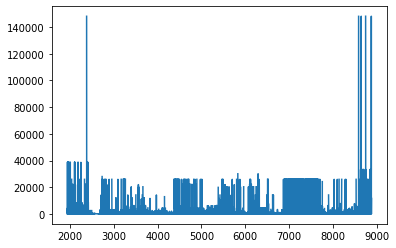

In [9]:
print('min: ',data['reviews'].min(), ' max: ', data['reviews'].max())
data['reviews'].plot()

In [10]:
#trying out modifying the df so I don't have a df per chart
source_lang = data['tag_language'].value_counts()
type(source_lang)
source_lang= data.groupby('tag_language')
type(source_lang)

pandas.core.groupby.generic.DataFrameGroupBy

In [11]:
#Lanugauges
data['tag_language'].nunique()
source_lang = pd.DataFrame(data['tag_language'].value_counts()).reset_index()
source_lang = source_lang.rename(columns = {'index':'Posting Language', 'tag_language':'Count'})
type(source_lang)

pandas.core.frame.DataFrame

In [12]:
alt.Chart(source_lang).mark_bar().encode(
    x=alt.X('Count', stack ='normalize'),
    #y='Posting Language',
    color = 'Count'
)


alt.Chart(...)

In [13]:
alt.Chart(source_lang).transform_joinaggregate(
    Total='sum(Count)',
).transform_calculate(
    Percentage="datum.Count / datum.Total"
).mark_bar().encode(
    alt.X('Percentage:Q', axis=alt.Axis(format='.0%')),
    y='Posting Language:N'
)

alt.Chart(...)

In [14]:
#Companies
print('Hiring Companies: ', data['company'].nunique())
source_comp = pd.DataFrame(data['company'].value_counts().reset_index())
source_comp= source_comp.rename(columns = {'index':'Company', 'company':'Count'})
source_comp

Hiring Companies:  2647


,Company,Count
0,Amazon.com,324
1,Ball Aerospace,187
2,Microsoft,136
3,Google,90
4,NYU Langone Health,77
...,...,...
2642,Gelber Group,1
2643,Construction Realty Services Group,1
2644,Rand Thompson Consultants LLC,1
2645,Georgia State University,1


In [15]:
source_comp = source_comp.nlargest(30, 'Count')

bars = alt.Chart(source_comp).mark_bar().encode(
    x='Count:Q',
    y=alt.Y('Company:N', sort='-x')
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='Count:Q'
)

(bars + text).properties(height=500)

alt.LayerChart(...)

In [16]:
#query_text
print('No of query_text: ',data['query_text'].nunique())
source_job = pd.DataFrame(data['query_text'].value_counts().reset_index())
source_job= source_job.rename(columns = {'index':'Job', 'query_text':'Count'})
source_job

No of query_text:  4


,Job,Count
0,data scientist,303
1,data science,295
2,business intelligence,290
3,data engineer,263


In [17]:
alt.Chart(source_job).mark_bar().encode(
    x='Count',
    y='Job'
)
#rule = alt.Chart(source_job).mark_rule(color='red').encode(
#    x='mean(Count):Q'
#)

alt.Chart(...)

In [18]:
type(data['job_text_tokenized'][0])

list

In [19]:
from fydjob import utils
utils.load_skills()     #loads the skills from JSON file


{'business': ['profitable',
  'administrative',
  'strategy',
  'kpi',
  'client',
  'analysis',
  'efficiency',
  'measurable',
  'crm',
  'visualization',
  'analyze',
  'analytical',
  'scm',
  'accounting',
  'olap',
  'consult',
  'feasibility',
  'strategic',
  'management',
  'solution',
  'industry',
  'dashboards',
  'strategical',
  'administration',
  'advertising',
  'managing',
  'analyse',
  'report',
  'analytic',
  'marketing',
  'entrepreneur',
  'sales',
  'distribution',
  'analytics',
  'analyst',
  'hr',
  'stakeholder',
  'reporting',
  'entrepreneurship',
  'entrepreneurial',
  'commercial',
  'planning',
  'consulting',
  'business',
  'visualisation',
  'bd',
  'logistic'],
 'knowledge': ['reinforcement',
  'gis',
  'correlation',
  'dbaas',
  'etl',
  'lstm',
  'optimization',
  'classification',
  'pca',
  'algorithmic',
  'nvidias',
  'optimizing',
  'uxui',
  'gbm',
  'quantitative',
  'econometric',
  'clustering',
  'queries',
  'logistics',
  'segmentati

In [20]:
# get all the skill sets
categories = utils.load_skills()
categories.keys()
bus_skills = set(utils.load_skills()['business'])
knowledge_skills = set(utils.load_skills()['knowledge'])
code_skills = set(utils.load_skills()['programming'])
soft_skills = set(utils.load_skills()['soft_skills'])


In [21]:
#get skill for the first token
skill_0 = []

for word in data['job_text_tokenized'][0]:
    if word in code_skills:
        skill_0.append(word)
        
skill_0

['sql',
 'python',
 'git',
 'redshift',
 'bigquery',
 'google',
 'microsoft',
 'google',
 'google',
 'cloud',
 'aws',
 'datadriven',
 'sql',
 'python',
 'git',
 'redshift',
 'bigquery',
 'google',
 'google',
 'cloud',
 'aws',
 'aws',
 'sql',
 'google']

In [22]:
# count the occurences
from collections import Counter
counter0 = Counter(data['job_text_tokenized'][0])

#occs = {x: counter[x] for x in counter.keys() & set(skill_0)}

bus_occs = {x: counter0[x] for x in counter0.keys() & set(bus_skills)}
code_occs = {x: counter0[x] for x in counter0.keys() & set(code_skills)}
knowledge_occs ={x: counter0[x] for x in counter0.keys() & set(knowledge_skills)}
soft_occs ={x: counter0[x] for x in counter0.keys() & set(soft_skills)}
    
print(bus_occs)
print(code_occs)
print(knowledge_occs)
print(soft_occs)


{'marketing': 10, 'analyse': 2, 'industry': 4, 'management': 1, 'business': 2, 'consult': 1, 'stakeholder': 1, 'analytics': 5, 'crm': 1, 'reporting': 2, 'analysis': 1, 'consulting': 2, 'analyst': 2, 'accounting': 1, 'analytical': 2, 'dashboards': 1}
{'cloud': 2, 'google': 6, 'redshift': 2, 'datadriven': 1, 'aws': 3, 'python': 2, 'bigquery': 2, 'microsoft': 1, 'git': 2, 'sql': 3}
{'optimization': 2, 'quantitative': 1, 'hardware': 2, 'statistics': 1, 'science': 1}
{'flexible': 3, 'time': 1, 'vision': 2, 'management': 1, 'responsible': 2, 'motivation': 1}


In [23]:
jd_0 = set(data['job_text_tokenized'][5])
vacancy = data['job_text_tokenized'][5]
jd_0

{'a',
 'ability',
 'across',
 'adapt',
 'additional',
 'again',
 'all',
 'always',
 'an',
 'and',
 'apply',
 'are',
 'areas',
 'as',
 'associate',
 'associates',
 'at',
 'based',
 'be',
 'begin',
 'berlin',
 'best',
 'better',
 'bewerbung',
 'both',
 'care',
 'challenging',
 'client',
 'clinical',
 'clinics',
 'collection',
 'committed',
 'communication',
 'computer',
 'connect',
 'constant',
 'constantly',
 'contact',
 'countries',
 'data',
 'degree',
 'department',
 'desire',
 'detail',
 'development',
 'diesen',
 'disabilities',
 'do',
 'doctors',
 'documents',
 'dont',
 'driven',
 'due',
 'eeoaa',
 'employees',
 'employer',
 'enable',
 'english',
 'ensure',
 'environment',
 'essential',
 'europe',
 'european',
 'evaluating',
 'expansion',
 'external',
 'eye',
 'fast',
 'fluency',
 'focused',
 'following',
 'for',
 'function',
 'gerade',
 'germany',
 'geschaltet',
 'given',
 'global',
 'have',
 'here',
 'highly',
 'hospitals',
 'improving',
 'in',
 'include',
 'individuals',
 'initi

In [24]:
jd_0.intersection(bus_skills)

{'client', 'management'}

In [25]:
jd_0.intersection(code_skills)

set()

In [26]:
jd_0.intersection(soft_skills)

{'committed',
 'communication',
 'driven',
 'management',
 'proactive',
 'project',
 'training',
 'verbal'}

In [27]:
jd_0.intersection(knowledge_skills)

{'query', 'science'}

In [28]:
for skill in categories:
    print(skill, jd_0.intersection(categories[skill]))


business {'client', 'management'}
knowledge {'science', 'query'}
programming set()
soft_skills {'driven', 'management', 'proactive', 'verbal', 'project', 'communication', 'committed', 'training'}


In [29]:
intersects_know = jd_0.intersection(knowledge_skills)
intersects_code = jd_0.intersection(code_skills)
intersects_soft = jd_0.intersection(soft_skills)
intersect_bus = jd_0.intersection(bus_skills)

In [30]:
vacancy.count('xgboost')

0

In [31]:
occsurrences_know ={} 
for skill in intersects_know:
    occsurrences_know[skill] = vacancy.count(skill)
occsurrences_know


{'science': 1, 'query': 1}

In [32]:
occsurrences_code ={} 
for skill in intersects_code:
    occsurrences_code[skill] = vacancy.count(skill)
occsurrences_code

{}

In [33]:
occsurrences_soft ={} 
for skill in intersects_soft:
    occsurrences_soft[skill] = vacancy.count(skill)
occsurrences_soft

{'driven': 1,
 'management': 5,
 'proactive': 1,
 'verbal': 1,
 'project': 1,
 'communication': 1,
 'committed': 2,
 'training': 3}

In [34]:
occsurrences_bus ={} 
for skill in intersects_soft:
    occsurrences_bus[skill] = vacancy.count(skill)
occsurrences_bus


{'driven': 1,
 'management': 5,
 'proactive': 1,
 'verbal': 1,
 'project': 1,
 'communication': 1,
 'committed': 2,
 'training': 3}

In [35]:
categories

{'business': ['profitable',
  'administrative',
  'strategy',
  'kpi',
  'client',
  'analysis',
  'efficiency',
  'measurable',
  'crm',
  'visualization',
  'analyze',
  'analytical',
  'scm',
  'accounting',
  'olap',
  'consult',
  'feasibility',
  'strategic',
  'management',
  'solution',
  'industry',
  'dashboards',
  'strategical',
  'administration',
  'advertising',
  'managing',
  'analyse',
  'report',
  'analytic',
  'marketing',
  'entrepreneur',
  'sales',
  'distribution',
  'analytics',
  'analyst',
  'hr',
  'stakeholder',
  'reporting',
  'entrepreneurship',
  'entrepreneurial',
  'commercial',
  'planning',
  'consulting',
  'business',
  'visualisation',
  'bd',
  'logistic'],
 'knowledge': ['reinforcement',
  'gis',
  'correlation',
  'dbaas',
  'etl',
  'lstm',
  'optimization',
  'classification',
  'pca',
  'algorithmic',
  'nvidias',
  'optimizing',
  'uxui',
  'gbm',
  'quantitative',
  'econometric',
  'clustering',
  'queries',
  'logistics',
  'segmentati

In [36]:
for category in categories:
    print(category)

business
knowledge
programming
soft_skills


In [37]:
vacancy = data['job_text_tokenized'][5]
vacancy_set = set(vacancy)
matching_skill_per_category = {}

for category in categories:
    matching_skill_per_category[str(category)]=vacancy_set.intersection(categories[category])
#print(matching_skill_per_category)
    
occ = {}
for category in categories:
    occ[category] = {}
    for s in matching_skill_per_category[str(category)]:
        occ[category][s] =  vacancy.count(s)
print(occ)


{'business': {'client': 1, 'management': 5}, 'knowledge': {'science': 1, 'query': 1}, 'programming': {}, 'soft_skills': {'driven': 1, 'management': 5, 'proactive': 1, 'verbal': 1, 'project': 1, 'communication': 1, 'committed': 2, 'training': 3}}


In [38]:
data['job_text_tokenized']

0       [customlytics, ist, die, führende, app, market...
1       [responsibilities, as, working, student, mfx, ...
2       [aufgaben, als, werkstudent, mwd, it, arbeites...
3       [startdatum, ab, sofort, deine, aufgaben, dein...
4       [were, phiture, a, leading, mobile, growth, co...
                              ...                        
8881    [are, you, datadriven, we, at, netapp, believe...
8882    [pharmacyclics, is, committed, to, the, develo...
8883    [oath, a, subsidiary, of, verizon, is, a, valu...
8884    [we, are, the, bing, core, relevance, team, re...
8885    [comcasts, technology, amp, product, organizat...
Name: job_text_tokenized, Length: 7859, dtype: object

In [39]:
occ

{'business': {'client': 1, 'management': 5},
 'knowledge': {'science': 1, 'query': 1},
 'programming': {},
 'soft_skills': {'driven': 1,
  'management': 5,
  'proactive': 1,
  'verbal': 1,
  'project': 1,
  'communication': 1,
  'committed': 2,
  'training': 3}}

In [40]:
for vacancy in data['job_text_tokenized'][:3]:
    set(vacancy)

In [41]:
type(data['job_text_tokenized'].values)

numpy.ndarray

In [42]:
categories

{'business': ['profitable',
  'administrative',
  'strategy',
  'kpi',
  'client',
  'analysis',
  'efficiency',
  'measurable',
  'crm',
  'visualization',
  'analyze',
  'analytical',
  'scm',
  'accounting',
  'olap',
  'consult',
  'feasibility',
  'strategic',
  'management',
  'solution',
  'industry',
  'dashboards',
  'strategical',
  'administration',
  'advertising',
  'managing',
  'analyse',
  'report',
  'analytic',
  'marketing',
  'entrepreneur',
  'sales',
  'distribution',
  'analytics',
  'analyst',
  'hr',
  'stakeholder',
  'reporting',
  'entrepreneurship',
  'entrepreneurial',
  'commercial',
  'planning',
  'consulting',
  'business',
  'visualisation',
  'bd',
  'logistic'],
 'knowledge': ['reinforcement',
  'gis',
  'correlation',
  'dbaas',
  'etl',
  'lstm',
  'optimization',
  'classification',
  'pca',
  'algorithmic',
  'nvidias',
  'optimizing',
  'uxui',
  'gbm',
  'quantitative',
  'econometric',
  'clustering',
  'queries',
  'logistics',
  'segmentati

In [43]:
#vacancy = data['job_text_tokenized'][5]


def get_skill_count(vacancy):
    # turn the vacancy into a set to compare the words with defined dictionary
    vacancy_set = set(vacancy)
    # get the matching skills of a job description to the skills defined within different categories of skillsets (tech, bus, softskill...)
    matching_skill_per_category = {}
    for category in categories:
        matching_skill_per_category[str(category)]=vacancy_set.intersection(categories[category])
    
    #count the occurences of every matching skill
    occurrences = {}
    for category in categories:
        occurrences[category] = {}
        for skill in matching_skill_per_category[str(category)]:
            occurrences[category][skill] =  vacancy.count(skill)
    return occurrences

In [44]:
requirement = {}
for index, vacancy in enumerate(data['job_text_tokenized']):
    #print(vacancy)
    requirement[index]= get_skill_count(vacancy)
    occurence =get_skill_count(vacancy)
    

In [45]:
requirement

{0: {'business': {'marketing': 10,
   'analyse': 2,
   'industry': 4,
   'management': 1,
   'business': 2,
   'consult': 1,
   'stakeholder': 1,
   'analytics': 5,
   'crm': 1,
   'reporting': 2,
   'analysis': 1,
   'consulting': 2,
   'analyst': 2,
   'accounting': 1,
   'analytical': 2,
   'dashboards': 1},
  'knowledge': {'optimization': 2,
   'quantitative': 1,
   'hardware': 2,
   'statistics': 1,
   'science': 1},
  'programming': {'cloud': 2,
   'google': 6,
   'redshift': 2,
   'datadriven': 1,
   'python': 2,
   'aws': 3,
   'bigquery': 2,
   'microsoft': 1,
   'git': 2,
   'sql': 3},
  'soft_skills': {'flexible': 3,
   'management': 1,
   'time': 1,
   'vision': 2,
   'responsible': 2,
   'motivation': 1}},
 1: {'business': {'marketing': 1,
   'business': 3,
   'analyst': 1,
   'dashboards': 1},
  'knowledge': {'etl': 1,
   'database': 1,
   'scrum': 1,
   'statistics': 1,
   'query': 1,
   'science': 2,
   'api': 1},
  'programming': {'aws': 1, 'python': 1, 'sql': 1, 'tabl

In [46]:
#things to do for streamlit

# ranking of all skills for streamlit --> agregated view of each categ
# percentage of category per job offer (10% bus, 20% tech...)

In [47]:
#put all vacancies into one huge list
all_vacancies=[]
for job in data['job_text_tokenized']:
    #print(len(job))
    all_vacancies = all_vacancies + job

In [48]:
len(all_vacancies)

4065741

In [49]:
vacancy_set = set(all_vacancies)
len(vacancy_set)

67123

In [50]:

matching_skill_per_category = {}

for category in categories:
    matching_skill_per_category[str(category)]=vacancy_set.intersection(categories[category])
#print(matching_skill_per_category)
occ = {}
for category in categories:
    occ[category] = {}
    for s in matching_skill_per_category[str(category)]:
        occ[category][s] =  all_vacancies.count(s)
print(occ)

{'business': {'efficiency': 570, 'managing': 1508, 'client': 2340, 'logistic': 120, 'olap': 21, 'analytics': 6358, 'administration': 644, 'profitable': 84, 'analyst': 1444, 'accounting': 388, 'analytical': 3883, 'entrepreneur': 38, 'dashboards': 399, 'business': 13710, 'feasibility': 177, 'strategical': 3, 'marketing': 3491, 'strategic': 2260, 'management': 8711, 'bd': 19, 'visualization': 1189, 'solution': 870, 'crm': 311, 'planning': 1859, 'kpi': 44, 'sales': 2040, 'commercial': 1168, 'visualisation': 40, 'strategy': 2170, 'stakeholder': 226, 'reporting': 2032, 'advertising': 950, 'analyze': 2034, 'administrative': 497, 'distribution': 305, 'analyse': 167, 'industry': 3911, 'report': 979, 'consult': 147, 'measurable': 100, 'analysis': 9066, 'hr': 341, 'entrepreneurship': 33, 'consulting': 1159, 'entrepreneurial': 534, 'analytic': 916, 'scm': 7}, 'knowledge': {'recurrent': 25, 'svm': 61, 'classification': 487, 'geospatial': 212, 'reinforcement': 90, 'query': 251, 'outlier': 19, 'regre

In [51]:
def get_skill_aggr(all_vacancies):
    
    vacancy_set = set(all_vacancies)
    matching_skill_per_category = {}

    for category in categories:
        matching_skill_per_category[str(category)]=vacancy_set.intersection(categories[category])
    
    occ = {}
    for category in categories:
        occ[category] = {}
        for s in matching_skill_per_category[str(category)]:
            occ[category][s] =  all_vacancies.count(s)
    return occ

In [52]:
all_vacancies=[]
for job in data['job_text_tokenized']:
    #print(len(job))
    all_vacancies = all_vacancies + job
total_occurences = get_skill_aggr(all_vacancies)
total_occurences

{'business': {'efficiency': 570,
  'managing': 1508,
  'client': 2340,
  'logistic': 120,
  'olap': 21,
  'analytics': 6358,
  'administration': 644,
  'profitable': 84,
  'analyst': 1444,
  'accounting': 388,
  'analytical': 3883,
  'entrepreneur': 38,
  'dashboards': 399,
  'business': 13710,
  'feasibility': 177,
  'strategical': 3,
  'marketing': 3491,
  'strategic': 2260,
  'management': 8711,
  'bd': 19,
  'visualization': 1189,
  'solution': 870,
  'crm': 311,
  'planning': 1859,
  'kpi': 44,
  'sales': 2040,
  'commercial': 1168,
  'visualisation': 40,
  'strategy': 2170,
  'stakeholder': 226,
  'reporting': 2032,
  'advertising': 950,
  'analyze': 2034,
  'administrative': 497,
  'distribution': 305,
  'analyse': 167,
  'industry': 3911,
  'report': 979,
  'consult': 147,
  'measurable': 100,
  'analysis': 9066,
  'hr': 341,
  'entrepreneurship': 33,
  'consulting': 1159,
  'entrepreneurial': 534,
  'analytic': 916,
  'scm': 7},
 'knowledge': {'recurrent': 25,
  'svm': 61,
  '

In [53]:
df = pd.DataFrame(total_occurences).reset_index()
df= df.rename(columns = {'index':'skill'})

df

,skill,business,knowledge,programming,soft_skills
0,efficiency,570.0,NaN,NaN,NaN
1,managing,1508.0,NaN,NaN,NaN
2,client,2340.0,NaN,NaN,NaN
3,logistic,120.0,120.0,NaN,NaN
4,olap,21.0,NaN,NaN,NaN
...,...,...,...,...,...
386,selfinitiative,NaN,NaN,NaN,9.0
387,dependable,NaN,NaN,NaN,28.0
388,presentation,NaN,NaN,NaN,1053.0
389,trustful,NaN,NaN,NaN,6.0


In [ ]:
if df['business'] >0:
    df['category'] = 'business'

In [ ]:
for category in df.columns[1:]:
    #print(df[category])
    if df.loc[df[category] > 0,:]:
              df['category']=category
#df.loc[df['a'] > 10, ['a','c']]

In [56]:
df_bus = df[['skill','business']].dropna().sort_values('business', ascending = False).rename(columns = {'business':'count'})
df_bus['category']='business'


In [57]:
df_know = df[['skill','knowledge']].dropna().sort_values('knowledge', ascending = False).rename(columns = {'knowledge':'count'})
df_know['category']='knowledge'


In [58]:
df_code = df[['skill','programming']].dropna().sort_values('programming', ascending = False).rename(columns = {'programming':'count'})
df_code['category']='programming'


In [59]:
df_soft = df[['skill','soft_skills']].dropna().sort_values('soft_skills', ascending = False).rename(columns = {'soft_skills':'count'})
df_soft['category']='soft skills'


In [60]:
df_categ = df_bus.append(df_know).append(df_code).append(df_soft)


In [61]:
df_categ['category'].unique()

array(['business', 'knowledge', 'programming', 'soft skills'],
      dtype=object)

In [64]:
source = df_categ.nlargest(100, 'count')
categs = np.array(df_categ['category'].unique())
category = np.insert(categs, 0, 'all')


#Dropdownbox
input_dropdown = alt.binding_select(options = category)
selection = alt.selection_single(fields = ['category'], bind = input_dropdown, name= 'Skill ')

alt.Chart(source).mark_bar().encode(
x = ('count:Q'),
y = alt.Y('skill',sort='-x'),
).add_selection(selection).transform_filter(
    selection)


alt.Chart(...)

In [ ]:
from vega_datasets import data
movies = alt.UrlData(
    data.movies.url,
    format=alt.DataFormat(parse={"Release_Date":"date"})
)
movies

In [ ]:
movies_df = pd.read_json('https://cdn.jsdelivr.net/npm/vega-datasets@v1.29.0/data/movies.json')

In [ ]:
movies_df


In [ ]:
ratings = ['G', 'NC-17', 'PG', 'PG-13', 'R']
genres = ['Action', 'Adventure', 'Black Comedy', 'Comedy',
       'Concert/Performance', 'Documentary', 'Drama', 'Horror', 'Musical',
       'Romantic Comedy', 'Thriller/Suspense', 'Western']

base = alt.Chart(movies, width=200, height=200).mark_point(filled=True).transform_calculate(
    Rounded_IMDB_Rating = "floor(datum.IMDB_Rating)",
    Hundred_Million_Production =  "datum.Production_Budget > 100000000.0 ? 100 : 10",
    Release_Year = "year(datum.Release_Date)"
).transform_filter(
    alt.datum.IMDB_Rating > 0
).transform_filter(
    alt.FieldOneOfPredicate(field='MPAA_Rating', oneOf=ratings)
).encode(
    x=alt.X('Worldwide_Gross:Q', scale=alt.Scale(domain=(100000,10**9), clamp=True)),
    y='IMDB_Rating:Q',
    tooltip="Title:N"
)

genre_dropdown = alt.binding_select(options=genres)
genre_select = alt.selection_single(fields=['Major_Genre'], bind=genre_dropdown, name="Genre")

filter_genres = base.add_selection(
    genre_select
).transform_filter(
    genre_select
).properties(title="Dropdown Filtering")

filter_genres

## Vectorizer


In [65]:

'''
instanciate a model with the .load method and select the path to the saved .model files
'''

w2v_model = Word2Vec.load("../fydjob/data/models/w2v_model_baseline.model")



In [66]:
word = ['business', 'dashboard']
df_words= pd.DataFrame(w2v_model.wv.most_similar(word), columns=['Similar word', 'distance']) # works with single words
df_words

,Similar word,distance
0,metrics,0.780442
1,selfservice,0.776556
2,crosschannel,0.767714
3,dashboards,0.749835
4,reporting,0.737683
5,analytics,0.724615
6,kpis,0.724004
7,marketing,0.717334
8,recommendations,0.714178
9,insights,0.713545


In [69]:
from fydjob.Word2VecPipeline import WordPipeline

model = WordPipeline("../fydjob/data/models/w2v_model_baseline.model")

In [84]:
word = 'python'
no_rec = 5

model.most_similar_skills(word,n_recommendations= no_rec)

['r', 'scala', 'java', 'perl', 'matlab']